<a href="https://colab.research.google.com/github/morenoloza98/Notebooks/blob/master/MazeSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes
Kevin A. Ruvalcaba Perez - A01652241 
https://github.com/KevinRuvalcaba/sistemas-inteligentes

Santiago Gutiérrez Bárcenas - A01652520
https://github.com/SantiagoGutierrezB/Sistemas_Inteligentes

Alejandro Moreno Loza - A01654319
https://github.com/morenoloza98/Notebooks

Diego Moreno Rodríguez A01337594
https://github.com/DiegoMoreno1110/Sistemas_Inteligentes_

In [ ]:
import heapq
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Helper functions and classes
class Vertex:
    def __init__(self,x_coord,y_coord):
        self.x=x_coord
        self.y=y_coord
        self.d=float('inf') #distance from source
        self.parent_x=None
        self.parent_y=None
        self.processed=False
        self.index_in_queue=None

#Return neighbor directly above, below, right, and left
def get_neighbors(mat,r,c):
    shape=mat.shape
    neighbors=[]
    #ensure neighbors are within image boundaries
    if r > 0 and not mat[r-1][c].processed:
         neighbors.append(mat[r-1][c])
    if r < shape[0] - 1 and not mat[r+1][c].processed:
            neighbors.append(mat[r+1][c])
    if c > 0 and not mat[r][c-1].processed:
        neighbors.append(mat[r][c-1])
    if c < shape[1] - 1 and not mat[r][c+1].processed:
            neighbors.append(mat[r][c+1])
    return neighbors



The bubble_up function moves selected vertex closer in the heap until it reaches a parent with a lower distance.



In [ ]:
def bubble_up(queue, index):
    if index <= 0: # We are done 
        return queue
    p_index=(index-1)//2 #index of the parent
    if queue[index].d < queue[p_index].d: #every unvisited vertex starts at inf distance
            queue[index], queue[p_index]= queue[p_index], queue[index] #Flip th vertex position
            queue[index].index_in_queue=index # change the pivots queue pos to the original
            queue[p_index].index_in_queue=p_index # change the original vertex queue pos to the pivot
            queue = bubble_up(queue, p_index) #recrusive call to move the original down the heap.
    return queue


Bubble_down pushes the vertex in the heap until it reaches a child that has a higher distance than his.  

In [ ]:

def bubble_down(queue, index):
    length=len(queue)
    lc_index=2*index+1 # left child index 
    rc_index=lc_index+1 # right child index
    if lc_index >= length:
        return queue # we are at the end of the heap.
    # This is skipped in the first pass
    if lc_index < length and rc_index >= length: #just process left child
        if queue[index].d > queue[lc_index].d:
            queue[index], queue[lc_index]=queue[lc_index], queue[index] #swap with child
            queue[index].index_in_queue=index #update index
            queue[lc_index].index_in_queue=lc_index #update index
            queue = bubble_down(queue, lc_index)
    else: # process both childs
        small = lc_index # index of the smalles distance.
        if queue[lc_index].d > queue[rc_index].d:
            small = rc_index # index of the smalles distance.
        if queue[small].d < queue[index].d: # Do the switch with child with less distance
            queue[index],queue[small]=queue[small],queue[index]
            queue[index].index_in_queue=index
            queue[small].index_in_queue=small
            queue = bubble_down(queue, small)
    return queue


Calcualtes distance based on their position in the image.

In [ ]:
def get_distance(img,u,v):
    return 0.1 + (float(img[v][0])-float(img[u][0]))**2+(float(img[v][1])-float(img[u][1]))**2+(float(img[v][2])-float(img[u][2]))**2

Colors the path of the solution.

In [ ]:
def drawPath(img,path, thickness=2):
    '''path is a list of (x,y) tuples'''
    x0,y0=path[0]
    for vertex in path[1:]:
        x1,y1=vertex
        cv2.line(img,(x0,y0),(x1,y1),(255,0,0),thickness)
        x0,y0=vertex

In [ ]:
def find_shortest_path(img,src,dst):
    pq=[] #min-heap priority queue
    source_x=src[0] #toma la coordenada en x del inicio
    source_y=src[1] #toma la coordenada en y del inicio
    dest_x=dst[0]   #toma la coordenada en x del destino
    dest_y=dst[1]   #toma la coordenada en y del destino
    imagerows,imagecols=img.shape[0],img.shape[1] #obtiene la cantidad de filas y columnas (en pixeles) de la imagen
    matrix = np.full((imagerows, imagecols), None) #access by matrix[row][col]
    for r in range(imagerows):
        for c in range(imagecols):
            matrix[r][c]=Vertex(c,r) #llena la matriz con los vertices
            matrix[r][c].index_in_queue=len(pq) # Indice que tiene en el min-heap
            pq.append(matrix[r][c]) # Agrega el objeto Vertex al min-heap
    '''
    Dijkstra asigna un valor de distancia al origen,
    al ser este el origen, se da una distancia de 0
    '''
    matrix[source_y][source_x].d=0 #Pon la distancia del source como cero por que ya estamos en ella.
    pq=bubble_up(pq, matrix[source_y][source_x].index_in_queue) 
    #Pasamos el heap para ir haciendo el recorrido hacia abajo y el indice de la fuente para saber donde empezar.
    
    # Calculate the distance of all vertexes and order 
    # based on distance them in the heap 
    while pq:
        u=pq[0] #el nodo sin visitar con menor valor
        u.processed=True #se marca el nodo como visitado
        #en las siguientes líneas, se saca el nodo visitado de la cola
        pq[0]=pq[-1] # save the last element at the head of the heap.
        pq[0].index_in_queue=0 # update index
        pq.pop() # eliminate the last one since we already changed it.
        pq=bubble_down(pq,0)
        '''
        se obtienen los vecinos del nodo en cuestión y sus
        respectivas distancias para obtener el siguiente nodo
        al que nos moveremos para ir encontrado el camino más corto
        '''
        neighbors = get_neighbors(matrix,u.y,u.x)
        for v in neighbors:
            # calulate the distance from the node we are processing to itrs neighbors.
            dist=get_distance(img,(u.y,u.x),(v.y,v.x))
            if u.d + dist < v.d:
                v.d = u.d+dist # update the distance
                v.parent_x=u.x # update the distance of parent
                v.parent_y=u.y # update the distance of parent
                idx=v.index_in_queue
                # Order the neighbor in the heap. 
                pq=bubble_down(pq,idx)
                pq=bubble_up(pq,idx)
                          
    path=[]
    # Vertex of my destination. 
    iter_v=matrix[dest_y][dest_x]
    # put it in the path, duh !!
    path.append((dest_x,dest_y))
    # append the vertices you traverse to the path
    while(iter_v.y!=source_y or iter_v.x!=source_x):
        path.append((iter_v.x,iter_v.y))
        iter_v=matrix[iter_v.parent_y][iter_v.parent_x]

    # append source vertex.
    path.append((source_x,source_y))
    return path

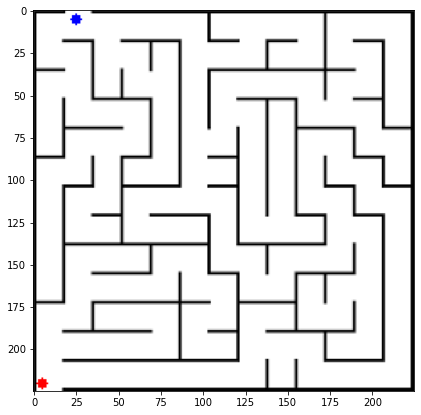

In [ ]:
img = cv2.imread('maze.png') # read the image 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (25,5), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7)) # set the size of the image
plt.imshow(img) # load figure from image
plt.show() # display image

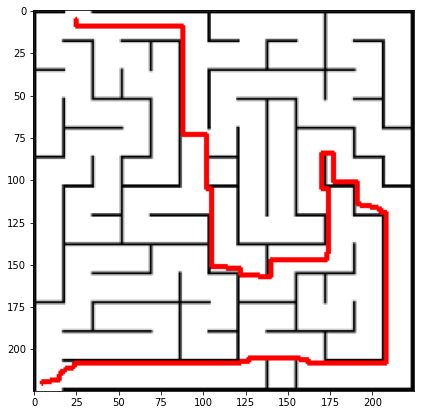

In [ ]:
img = cv2.imread('maze.png') # read image
cv2.imwrite('maze-initial.png', img) # wirte image
p = find_shortest_path(img, (25,5), (5,220))
drawPath(img,p)
cv2.imwrite('maze-solution.png', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()

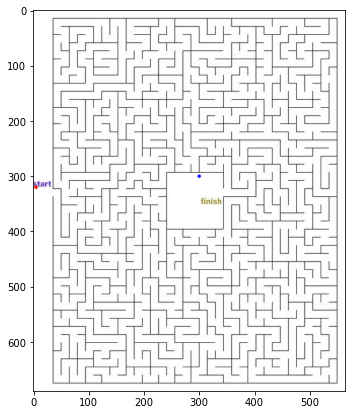

In [ ]:
img = cv2.imread('maze5.jpg') # read the image 
cv2.circle(img,(5,320), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (300,300), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

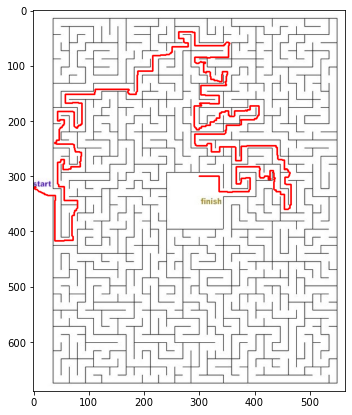

In [ ]:
img = cv2.imread('maze5.jpg') # read image
cv2.imwrite('maze-initial5.jpg', img)
p = find_shortest_path(img, (300,300), (5,320))
drawPath(img,p)
cv2.imwrite('maze-solution5.jpg', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()

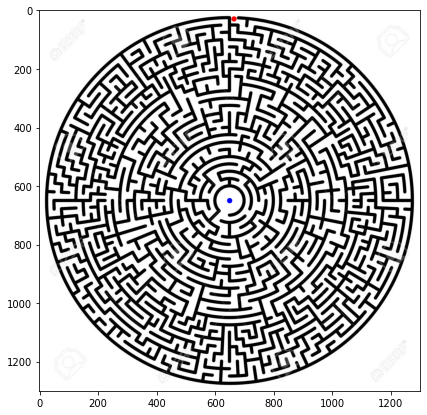

In [ ]:
img = cv2.imread('coolmaze.jpg') # read the image 
cv2.circle(img,(665, 30), 9, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (650,650),9, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()


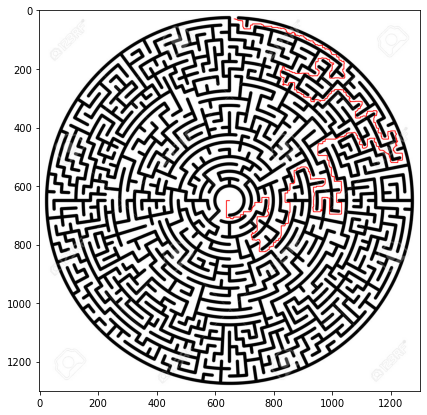

In [ ]:

img = cv2.imread('coolmaze.jpg') # read image
cv2.imwrite('coolmaze-initial5.jpg', img)
p = find_shortest_path(img, (650, 650), (665, 30))
drawPath(img,p)
cv2.imwrite('maze-solution5.jpg', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()